# 3D Transforms

In this example we demonstrate 3D WarpAffine and Rotate.

### Warp operators
All warp operators work by caclulating the output pixels by sampling the source image at transformed coordinates:

$${Out}(x, y, z) = {In}(x_{src}, y_{src}, z_{src})$$

This way each output pixel is calculated exactly once.

If the source coordinates do not point exactly to pixel centers, the values of neighboring pixels will be interpolated or the nearest pixel is taken, depending on the interpolation method specified in the `interp_type` argument.

### Affine transform

The source sample coordinates $x_{src}, y_{src}, z_{src}$ are calculated according to the formula:

$$
\begin{vmatrix}
x_{src} \\
y_{src} \\
z_{src}
\end{vmatrix}
= \begin{vmatrix}
m_{00} & m_{01} & m_{02} & t_x \\
m_{10} & m_{11} & m_{12} & t_y \\
m_{20} & m_{21} & m_{22} & t_z
\end{vmatrix}
\begin{vmatrix}
{x} \\
{y} \\
{z} \\
1
\end{vmatrix}
$$

Where $x, y$ are coordinates of the destination pixel and the matrix represents the inverse (destination to source) affine transform. The 
$\begin{vmatrix}
m_{00} & m_{01} & m_{02} \\
m_{10} & m_{11} & m_{12} \\
m_{20} & m_{21} & m_{22}
\end{vmatrix}$ block represents a combined rotate/scale/shear transform and $t_x, t_y, t_z$ is a translation vector.

### 3D Rotation

Rotate operator is implemented in terms of affine transform, but calculates the transform matrix internally. The output size is automatically adjusted and the size parity is adjusted to reduce blur near the volume centre. The rotation is defined by specifying axis (as a vector) and angle (in degrees).

The rotation matrix (source-to-destination) is calculated as:

$$
\begin{vmatrix}
u^2 + (v^2 + w^2) \cdot \cos \alpha &
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
uw\cdot(1-\cos \alpha) + v\cdot \sin \alpha \\
uv\cdot(1-\cos \alpha) - w\cdot \sin \alpha &
v^2 + (u^2 + w^2) \cdot \cos \alpha &
vw\cdot(1-\cos \alpha) - u\cdot \sin \alpha \\
uw\cdot(1-\cos \alpha) - v\cdot \sin \alpha &
vw\cdot(1-\cos \alpha + u\cdot \sin \alpha &
w^2 + (u^2 + w^2) \cdot \cos \alpha
\end{vmatrix}
$$
where $u, v, w$ is normalized `axis` vector and $\alpha$ is `angle` converted from degrees to radians.

Note that internally, the inverse matrix is used to achieve destination-to-source mapping, which is how the operation is actually implemented.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

Let's define some test data - in this case, it consists of edges of a cube

In [2]:
nvidia_green = [0x76,0xb9,0x00]
violet = [0xff - 0x76, 0xff - 0xb9, 0xff]

def lerp(a, b, w):
    return a*(1-w)+b*w

def build_cube(output_shape, size, color_front = nvidia_green, color_back = violet):
    color_front = np.array(color_front)
    color_back = np.array(color_back)
    arr = np.zeros(output_shape + [3], np.uint8)
    lo = (np.array(output_shape) - np.array(size)) * 0.5
    hi = (np.array(output_shape) + np.array(size)) * 0.5
    dims = len(output_shape)
    for d in range(dims):
        for c in range(int(np.rint(lo[d])), int(np.rint(hi[d]))):
            d0 = 0
            d1 = 1
            if d == 0:
                d0 = 1
                d1 = 2
            elif d == 1:
                d0 = 0
                d1 = 2
            p = [int(x) for x in lo]
            def color():
                return lerp(color_front, color_back, (p[0]-lo[0])/(hi[0]-lo[0]))

            p[d] = c
            arr[p[0], p[1], p[2], :] = color()
            p[d0] = int(np.rint(hi[d0]))
            arr[p[0], p[1], p[2], :] = color()
            p[d1] = int(np.rint(hi[d1]))
            arr[p[0], p[1], p[2], :] = color()
            p[d0] = int(np.rint(lo[d0]))
            arr[p[0], p[1], p[2], :] = color()
    return arr

Now, let's define the pipeline. The transform parameters are hard-coded, but axis, angle and matrix arguments can be specified as CPU tensors. The warp matrices can alternatively be passed as a regular input to the WarpAffine operator, in which case they can be passed as a GPU tensor.
See Warp example for exact usage.

In [3]:
class ExamplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(ExamplePipeline, self).__init__(
            batch_size, num_threads, device_id,
            seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        
        self.input = ops.ExternalSource()
       
        self.rotate_gpu = ops.Rotate(
            device = "gpu",
            axis = (0.5,1,1),
            angle = 30,
            interp_type = types.INTERP_LINEAR
        )
        self.rotate_cpu = ops.Rotate(
            device = "cpu",
            axis = (0.5,1,1),
            angle = 30,
            interp_type = types.INTERP_LINEAR
        )
        self.warp_gpu = ops.WarpAffine(
            device = "gpu",
            size = (256, 256, 400),
            matrix = (
                1, 1, 0,   -200,
                0, 1, 0.2, -20,
                0, 0, 1,   10
            ),
            interp_type = types.INTERP_LINEAR
        )
        
    # Then, we can tie the operators together to form a graph
        
    def define_graph(self):
        self.data = self.input()
        outputs = [self.data.gpu()]
        # pass the transform parameters through GPU memory
        outputs += [self.rotate_gpu(self.data.gpu()),
                    self.rotate_cpu(self.data).gpu(),
                    self.warp_gpu(self.data.gpu())]

        return outputs
    
    # Since we're using ExternalSource, we need to feed the externally provided data to the pipeline
    
    def iter_setup(self):
        # Generate the transforms for the batch and feed them to the ExternalSource
        self.feed_input(self.data, [build_cube([128,128,128],[80,80,80]), build_cube([160,160,160],[80,120,80])])    

The pipeline class is now ready to use - we need to construct and build it before we run it.

In [4]:
batch_size = 2
pipe = ExamplePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

Finally, we can call `run` on our pipeline to obtain the first batch of preprocessed images.

In [5]:
pipe_out = pipe.run()

## Example output

Now that we've processed the first batch of images, let's see the results. The output is projected by taking maximum intensity values along projection direction.

We use a perspective projection and the projected volume is displayed in left-handed coordinates, with X axis pointing right, Y axis pointing up and Z axis pointing away from the viewer.

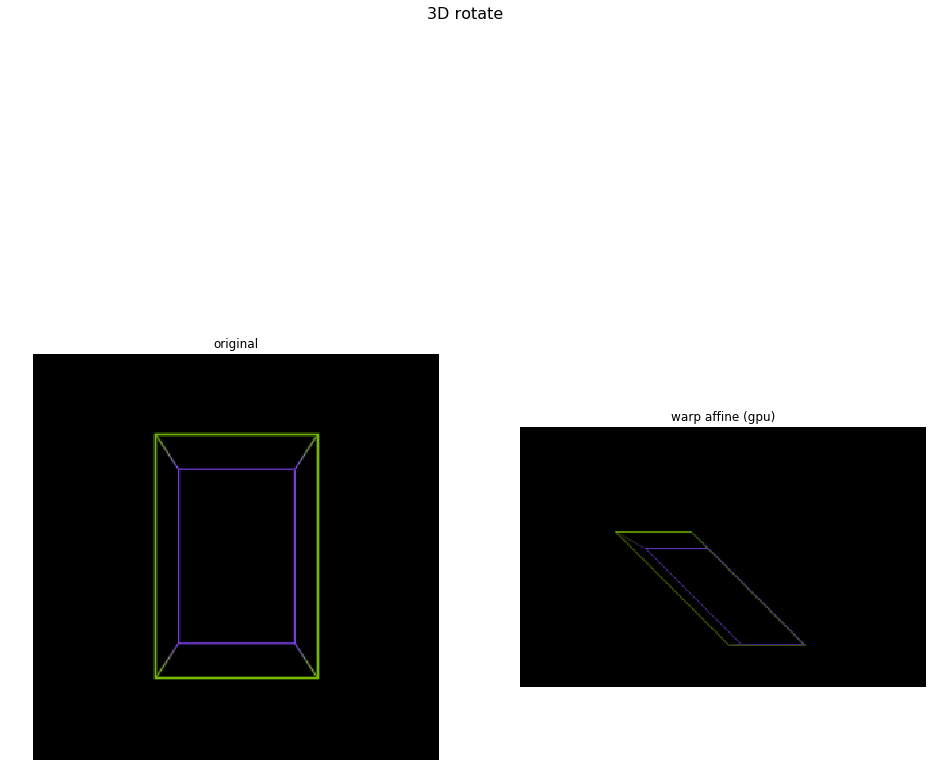

In [6]:
n = 1  # change this value to see other images from the batch;
       # it must be in 0..batch_size-1 range
    
import cv2
    
def centered_scale(in_size, out_size, scale):
    tx = (in_size[1]-out_size[1]/scale)/2
    ty = (in_size[0]-out_size[0]/scale)/2
    return np.array([[1/scale, 0, tx],
                     [0, 1/scale, ty]])

def project_volume(volume, out_size, eye_z, fovx = 90, zstep = 0.25):
    output = np.zeros(out_size + [volume.shape[-1]])
    in_size = volume.shape[1:3]
    fovx_z = math.tan(math.radians(fovx/2)) * volume.shape[2] / out_size[1]

    def project_slice(volume, plane_z):
        plane_index = int(plane_z)
        volume_slice = volume[plane_index]
        scale = volume_slice.shape[1] / fov_w
        M = centered_scale(in_size, out_size, scale)
        return cv2.warpAffine(volume_slice, M,
                              dsize = (out_size[1], out_size[0]),
                              flags = cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR)

    for plane_z in np.arange(0, volume.shape[0], zstep):
        z = plane_z - eye_z
        fov_w = z * fovx_z
        z0 = np.clip(math.floor(plane_z), 0, volume.shape[0]-1)
        z1 = np.clip(math.ceil(plane_z), 0, volume.shape[0]-1)
        projected_slice = project_slice(volume, z0)
        # trilinear interpolation
        if z1 != z0:
            slice1 = project_slice(volume, z1)
            q = (plane_z - np.floor(plane_z))
            projected_slice = (projected_slice * (1-q) + slice1*q).astype(np.uint8)

        np.maximum(output, projected_slice, out = output)

    return output


import matplotlib.gridspec as gridspec

len_outputs = len(pipe_out)

captions = ["original",
            "rotated (gpu)", "rotated (cpu)", "warp affine (gpu)"]

fig = plt.figure(figsize = (16,16))
plt.suptitle("3D rotate", fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)

for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(captions[i])
    pipe_out_cpu = pipe_out[i].as_cpu()
    volume = pipe_out_cpu.at(n)
    window_size = 300
    (h, w) = volume.shape[1:3]
    if h > w:
        w = window_size * w // h
        h = window_size
    else:
        h = window_size * h // w
        w = window_size
    img = project_volume(volume, [h,w], -volume.shape[2]) * (1 / 255.0)
    
    # Display in left-handed coordinates:
    # X axis points right
    # Y axis points up
    # Z axis points away
    plt.imshow(img, origin='lower')